### An example of `torch.distributions.Categorical()` and `sample()`

In [6]:
import torch
import torch.distributions as dist

# 假设我们的策略网络输出了一个包含四个动作的概率分布
action_probabilities = torch.tensor([0.2, 0.3, 0.1, 0.4])

# 创建Categorical分布对象
action_dist = dist.Categorical(action_probabilities)
print(action_dist)

# 从分布中随机采样一个动作
sampled_action_index = action_dist.sample()

print(sampled_action_index)
print(sampled_action_index.shape)
# 打印采样到的动作索引
print("Sampled Action Index:", sampled_action_index.item())

# 打印采样到的具体动作
sampled_action = sampled_action_index.item()
print("Sampled Action:", sampled_action)

Categorical(probs: torch.Size([4]))
tensor(3)
torch.Size([])
Sampled Action Index: 3
Sampled Action: 3


## REINFORCE

In [7]:
import torch
from torch import nn
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import rl_utils

### Policynet

In [8]:
class PolicyNet(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x):
        return torch.softmax(self.layer_stack(x), dim=1)

### REINFORCE

In [9]:
class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, device, gamma, learning_rate) -> None:
        self.policynet = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.gamma = gamma
        self.device = device
        self.optimizer = torch.optim.Adam(self.policynet.parameters(), lr=learning_rate)

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float, device=self.device)
        action_dist = torch.distributions.Categorical(self.policynet(state))
        action = action_dist.sample()
        return action.item()
    
    def update(self, transition_dict):
        state_list = transition_dict['states']
        action_list = transition_dict['actions']
        reward_list = transition_dict['rewards']
        G = 0
        self.optimizer.zero_grad()

        for i in reversed(range(len(action_list))):
            reward = reward_list[i]
            G = self.gamma * G + reward
            # assert self.policynet(states[i]).shape == actions[i].shape
            state = torch.tensor([state_list[i]], dtype=torch.float, device=self.device)
            action = torch.tensor([action_list[i]], device=self.device).view(-1, 1)
            # print(f'shape of not viewed action: {torch.tensor([action_list[i]], device=self.device)}')
            # print(f'Shape of action: {action}')
            # print(f'Shape of state: {state}')
            loss = -torch.log(self.policynet(state).gather(1, action)) * G
            loss.backward()

        self.optimizer.step()

### Training

In [10]:

device = 'cuda' if torch.cuda.is_available() else 'cpu' 
gamma = 0.98
learning_rate = 1e-3
num_episodes = 1000
env_name = 'CartPole-v0'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
np.random.seed()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 128
agent = REINFORCE(state_dim, hidden_dim, action_dim, device, gamma, learning_rate)


return_list = []
for i in range(10):
    with tqdm(total = int(num_episodes / 10), desc=f'Iteration: {i}') as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            done = False
            transition_dict = {
                'states': [],
                'actions': [],
                'rewards': []
            }
            while not done:
                transition_dict['states'].append(state)
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)
                transition_dict['actions'].append(action)
                transition_dict['rewards'].append(reward)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)


Iteration: 9: 100%|██████████| 100/100 [00:04<00:00, 21.96it/s, episode=1000, return=200.000]


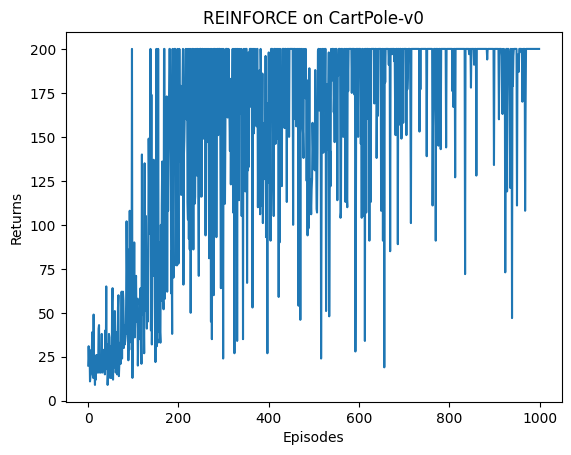

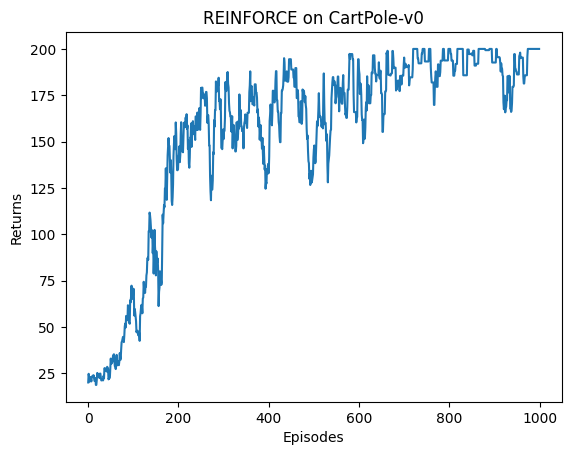

In [11]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()